In [168]:
import pandas as pd
from pandas import Series,DataFrame

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [169]:
titanic_df = pd.read_csv('train.csv')

In [170]:
def male_female_child(passenger):
    # 年齢と性別のデータを取得します。
    age,sex = passenger
    # 年齢を調べて16歳未満なら、子供。それ以外は性別をそのまま返します。
    if age < 16:
        return 3
    else:
        if sex == 'male':
            return 1
        else:
            return 2
    
# personという新しい列を追加します。
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(male_female_child,axis=1)

In [171]:
titanic_df['Alone'] = titanic_df.Parch + titanic_df.SibSp

In [172]:
titanic_df['Alone'].loc[titanic_df['Alone'] >0] = 1
titanic_df['Alone'].loc[titanic_df['Alone'] == 0] = 0

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [173]:
#titanic_df = titanic_df[titanic_df.Pclass == 1]

In [174]:
train_data = titanic_df.drop(['PassengerId','Name','Sex','SibSp','Parch','Fare', 'Ticket', 'Cabin', 'Embarked'], 1)

In [175]:
train_data.describe()

,Survived,Pclass,Age,Person,Alone
count,891.000000,891.000000,714.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,1.490460,0.397306
std,0.486592,0.836071,14.526497,0.660838,0.489615
min,0.000000,1.000000,0.420000,1.000000,0.000000
25%,0.000000,2.000000,20.125000,1.000000,0.000000
50%,0.000000,3.000000,28.000000,1.000000,0.000000
75%,1.000000,3.000000,38.000000,2.000000,1.000000
max,1.000000,3.000000,80.000000,3.000000,1.000000


In [176]:
train_data = train_data.fillna({'Age':28})

In [177]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Age         891 non-null float64
Person      891 non-null int64
Alone       891 non-null int64
dtypes: float64(1), int64(4)
memory usage: 34.9 KB


In [178]:
#train_data = train_data.dropna()

In [179]:
# separate sex
train_data.head()
#train_data = train_data[train_data.Pclass == 3]

,Survived,Pclass,Age,Person,Alone
0,0,3,22.0,1,1
1,1,1,38.0,2,1
2,1,3,26.0,2,0
3,1,1,35.0,2,1
4,0,3,35.0,1,0


In [180]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Age         891 non-null float64
Person      891 non-null int64
Alone       891 non-null int64
dtypes: float64(1), int64(4)
memory usage: 34.9 KB


In [181]:
t = train_data.iloc[:,0]
x = train_data.iloc[:,1:]

In [182]:
x = x.values

In [183]:
x = x.astype("f")
t = t.astype("i")

In [184]:
dataset = list(zip(x, t))

In [185]:
import chainer
import chainer.functions as F
import chainer.links as L
import chainer
import cupy

from chainer import training
from chainer.training import extensions

In [186]:
n_train = int(len(dataset)*0.7)

In [187]:
train, test = chainer.datasets.split_dataset_random(dataset, n_train, seed=1)

In [188]:
class NN(chainer.Chain):
    def __init__(self, n_mid_units1=3, n_out=2):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(None, n_mid_units1)
            self.fc2 = L.Linear(None, n_out)
            
            self.bn = L.BatchNormalization(4)
    
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [189]:
np.random.seed(1)
nn = NN()
model = L.Classifier(nn)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
batch_size = 10

In [190]:
train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size, repeat=False, shuffle=False)

In [191]:
updater = training.StandardUpdater(train_iter, optimizer, device=-1)

In [192]:
epoch = 100

In [193]:
trainer = training.Trainer(updater, (epoch, "epoch"), out="result/titanic")

trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
trainer.extend(extensions.LogReport(trigger=(1, "epoch")))
trainer.extend(extensions.PrintReport(["epoch", "main/accuracy", "validation/main/accuracy", "main/loss", "validation/main/loss"]))

In [194]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss
1           0.592063       0.641667                  0.652803    0.611579              
2           0.627419       0.702778                  0.621502    0.570564              
3           0.654839       0.730556                  0.602075    0.554694              
4           0.68254        0.728704                  0.580277    0.527163              
5           0.716129       0.793519                  0.580112    0.522006              
6           0.73871        0.802778                  0.561933    0.50279               
7           0.755556       0.80463                   0.554352    0.497228              
8           0.751613       0.80463                   0.558207    0.48211               
9           0.774194       0.80463                   0.530435    0.476275              
10          0.766129       0.80463                   0.537389    0.476949              
11          0.780952       0.80463

91          0.795238       0.819444                  0.457219    0.423382              
92          0.793548       0.819444                  0.459141    0.418503              
93          0.775806       0.812037                  0.456384    0.419237              
94          0.777778       0.815741                  0.463038    0.423849              
95          0.791935       0.80463                   0.459338    0.419861              
96          0.796774       0.819444                  0.452897    0.42085               
97          0.78254        0.819444                  0.461704    0.422184              
98          0.790323       0.819444                  0.452698    0.42503               
99          0.780645       0.819444                  0.483212    0.423024              
100         0.793548       0.819444                  0.447921    0.4199                


In [195]:
import json

In [196]:
with open("result/titanic/log") as f:
    logs = json.load(f)

In [197]:
results = pd.DataFrame(logs)

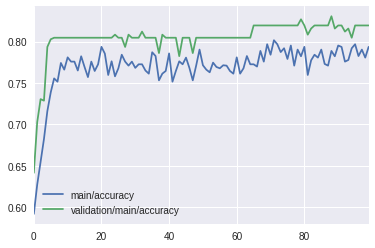

In [198]:
%matplotlib inline
results[["main/accuracy", "validation/main/accuracy"]].plot()

In [199]:
chainer.serializers.save_npz("models/titanic.npz", model)

In [200]:
model = L.Classifier(NN())
chainer.serializers.load_npz("models/titanic.npz", model)

In [201]:
titanic_df = pd.read_csv('test.csv')
titanic_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [202]:
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(male_female_child,axis=1)

In [203]:
titanic_df['Alone'] = titanic_df.Parch + titanic_df.SibSp

In [204]:
titanic_df['Alone'].loc[titanic_df['Alone'] >0] = 1
titanic_df['Alone'].loc[titanic_df['Alone'] == 0] = 0

/usr/local/pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [205]:
test_data = titanic_df.drop(['PassengerId','Name','Sex','SibSp','Parch','Fare', 'Ticket', 'Cabin', 'Embarked'], 1)

In [206]:
test_data = test_data.fillna({'Age':28})

In [207]:
x = test_data.values

In [208]:
x = x.astype("f")

In [209]:
survived = []

In [210]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    for x_ in x:
        x_new = x_
        x_new = x_new[np.newaxis]
    
        y = model.predictor(x_new)
        y = F.softmax(y)
        survived.append(np.argmax(y.array))

In [211]:
len(survived)

418

In [212]:
titanic_df['Survived'] = np.array(survived)

In [213]:
titanic_df.head(20)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,Alone,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2,1,0
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,3,0,1
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,2,0,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,1,1,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,2,0,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,1,1,0


In [216]:
predict_df = titanic_df.drop(['Name','Sex','SibSp','Parch','Fare', 'Ticket', 'Cabin', 'Embarked', 'Pclass', 'Age', 'Person', 'Alone'], 1)

In [217]:
predict_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [ ]:
predict_df.to_csv('predict_20181119')